In [169]:
'''
Vi importerer nødvendige biblioteker
og definerer globale variabler med stinavne/filnavne 
'''
from PIL import Image, ImageDraw
import csv
import os
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torch
import cv2
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchvision import models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from numpy import argmax
from sklearn.model_selection import train_test_split
import glob
import shutil
from sklearn.metrics import f1_score
import argparse

csvpath = 'classifier/license_plates_detection_train.csv'
trainingdatacsvpath = 'classifier/trainingdata.csv'
predictioncsvpath = 'classifier/license_plates_recognition_train.csv'

#imagepath = 'C:/Users/yusuf/Documents/GitHub/DeepLearning/DatasetDeeplearning/license_plates_detection_train/'
#csvpath = 'C:/Users/yusuf/Documents/GitHub/DeepLearning/DatasetDeeplearning/license_plates_detection_train.csv'
#croppedImagesPath = 'C:/Users/yusuf/Documents/GitHub/DeepLearning/DatasetDeeplearning/croppedImages/'
#trainingdatacsvpath = 'C:/Users/yusuf/Documents/GitHub/DeepLearning/trainingdata.csv'
#predictioncsvpath = 'C:/Users/yusuf/Documents/GitHub/DeepLearning/DatasetDeeplearning/license_plates_recognition_train.csv'
#testFolder = 'DatasetDeeplearning/TestImages/'
#trainFolder = 'DatasetDeeplearning/TestImages/'


# imagepath = 'C:/Users/chris/source/repos/DeepLearning/DatasetDeeplearning/license_plates_detection_train/'
# csvpath = 'C:/Users/chris/source/repos/DeepLearning/DatasetDeeplearning/license_plates_detection_train.csv'
# croppedImagesPath = 'C:/Users/chris/source/repos/DeepLearning/DatasetDeeplearning/croppedImages/'
# trainingdatacsvpath = 'C:/Users/chris/source/repos/DeepLearning/DatasetDeeplearning/trainingdata.csv'
# predictioncsvpath = 'C:/Users/chris/source/repos/DeepLearning/DatasetDeeplearning/license_plates_recognition_train.csv'
# testFolder = 'DatasetDeeplearning/TestImages/'
# trainFolder = 'DatasetDeeplearning/TestImages/'



In [170]:
'''
Vi definerer en klasse med billededata,
som vi kan definere nye obkejter af
'''
class ImageData:
    def __init__(self, path, ymin, xmin, ymax, xmax):
        self.path = path
        self.xmin = xmin      
        self.ymin = ymin        
        self.xmax = xmax        
        self.ymax = ymax

In [171]:
'''
En funktion som læser data fra .CSV fil, 
og opretter nye billededata objekter af denne data
(.CSV filen indeholder data om, hvor nummerpladen sidder (XY-koordinater))
'''
def read_image_data():
    file = open(csvpath)
    csvreader = csv.reader(file)
    rows = []
    next(csvreader)
    for row in csvreader:
            imgdt = ImageData(row[0], int(row[1]), int(row[2]), int(row[3]), int(row[4]))
            rows.append(imgdt)
    file.close()
    return rows


In [172]:
'''
Vi definerer en klasse,
som kun indeholder billedets navn (filnavn) og nummerpladen (string)
'''
class PredictionData:
    def __init__(self, path, licenseplate):
        self.path = path
        self.licenseplate = licenseplate

In [173]:
'''
En funktion som læser data fra .CSV filen,
og opretter nye objekter af PredictionData
'''
def read_prediction_data():
    file = open(predictioncsvpath)
    csvreader = csv.reader(file)
    rows = []
    next(csvreader)
    for row in csvreader:
            pd = PredictionData(row[0], row[1])
            rows.append(pd)
    file.close()
    return rows


In [174]:
'''
En funktion som laver vores data om til one-hot-encoding, som gemmes i en ny .CSV fil.
Vi behandler vores data, hvor one-hot-encoding deler vores data op i kategorier, 
som vores Deep learning algortime kan forstå.
'''
def onehot_encoding():
    predictiondata = read_prediction_data()
    numbers = '0123456789'
    onehot_encoded = list()
    #header = ['img_id', 'text', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    header = ['img_id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    with open(trainingdatacsvpath, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for data in predictiondata:
            # Vi fjerner T and N fra nummerpladen
            datatrimmed = data.licenseplate.replace('T', '')
            datatrimmed = datatrimmed.replace('N', '')

            # Vi laver nummerpladen om til en liste af nummerene fra nummerpladen
            char_to_int = dict((c, i) for i, c in enumerate(numbers))
            integer_encoded = [char_to_int[char] for char in datatrimmed] 
            #print(integer_encoded)

            # Vi laver nu one-hot-encode
            # 1 bliver sat, hvis det eksisterer i nummerpladen
            letter = [0 for _ in range(len(numbers))]
            for value in integer_encoded:
                letter[value] = 1
            
            # Billedets navn og den oprindelige nummerplade indsættes også i vores .CSV fil
            letter.insert(0, data.path)
            #letter.insert(1, data.licenseplate)
            
            writer.writerow(letter)
            onehot_encoded.append(letter)

onehot_encoding() 
    

In [175]:
'''
Vi laver en funktion, som kan visualisere vores data.
Der printes: 
    - shape (rækker, koloner)
    - head (de første 5 rækker)
    - tail (de sidste 5 rækker)
'''
def show_data_from_csv(csv_filepath: str):
    csv_data = pd.read_csv(csv_filepath)
    print("CSV shape:", csv_data.shape) 
    print("CSV head:")
    print(csv_data.head()) #det samme som csv_data[:5]
    print("CSV tail:")
    print(csv_data.tail()) #det samme som csv_data[-5:]

show_data_from_csv(trainingdatacsvpath) #"train.csv"


CSV shape: (900, 11)
CSV head:
    img_id  0  1  2  3  4  5  6  7  8  9
0    0.jpg  0  1  0  1  0  0  0  1  1  1
1    1.jpg  1  1  1  0  0  0  1  0  1  0
2   10.jpg  0  0  0  1  1  1  0  0  1  1
3  100.jpg  0  1  0  1  0  0  1  1  0  1
4  101.jpg  0  0  0  0  0  1  1  1  1  1
CSV tail:
     img_id  0  1  2  3  4  5  6  7  8  9
895  95.jpg  1  0  0  1  0  0  0  1  1  1
896  96.jpg  0  0  1  0  0  1  0  0  1  1
897  97.jpg  1  1  0  0  0  0  1  1  1  0
898  98.jpg  0  0  0  1  0  0  1  1  1  1
899  99.jpg  0  1  0  0  1  1  0  0  1  1


In [176]:
class CustomImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['img_id']
        self.all_labels = np.array(self.csv.drop(['img_id'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        if self.train == True:
                print(f"Number of training images: {self.train_ratio}")
                self.image_names = list(self.all_image_names[:self.train_ratio])
                self.labels = list(self.all_labels[:self.train_ratio])
                # define the training transforms
                self.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((25, 25)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(degrees=45),
                    transforms.ToTensor(),
                ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((25, 25)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
            # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"C:/Users/thoma/Documents/Softwareudvikling/Deep_learning/Eksamensprojekt/kode/DeepLearning/Opg1_multilabel_classification/classifier/multilabel_dataset/Images/{self.image_names[index]}")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [177]:
from torchvision import models as models
import torch.nn as nn
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 10 classes in total
    model.fc = nn.Linear(2048, 10)
    return model

In [178]:
import torch
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [179]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [180]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [181]:
#intialize the model
model = model(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.0001
epochs = 20
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [182]:
# read the training csv file
train_csv = pd.read_csv(trainingdatacsvpath)
# train dataset
train_data = CustomImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = CustomImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 765
Number of validation images: 135


In [183]:
# start the training and validation
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 20
Training


  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\thoma\AppData\Local\Temp/ipykernel_24328/1235589087.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
24it [00:01, 21.56it/s]                        


Validating


4it [00:00, 43.01it/s]               


Train Loss: 0.6940
Val Loss: 0.7636
Epoch 2 of 20
Training


24it [00:00, 37.44it/s]                        


Validating


4it [00:00, 43.96it/s]               


Train Loss: 0.6854
Val Loss: 1.1259
Epoch 3 of 20
Training


24it [00:00, 38.16it/s]                        


Validating


4it [00:00, 44.94it/s]               


Train Loss: 0.6867
Val Loss: 1.0094
Epoch 4 of 20
Training


24it [00:00, 34.88it/s]                        


Validating


4it [00:00, 40.00it/s]               


Train Loss: 0.6768
Val Loss: 0.8896
Epoch 5 of 20
Training


24it [00:00, 34.68it/s]                        


Validating


4it [00:00, 40.82it/s]               


Train Loss: 0.6775
Val Loss: 0.8152
Epoch 6 of 20
Training


24it [00:00, 35.66it/s]                        


Validating


4it [00:00, 38.10it/s]               


Train Loss: 0.6773
Val Loss: 0.9938
Epoch 7 of 20
Training


24it [00:00, 35.35it/s]                        


Validating


4it [00:00, 39.60it/s]               


Train Loss: 0.6767
Val Loss: 0.9758
Epoch 8 of 20
Training


24it [00:00, 35.67it/s]                        


Validating


4it [00:00, 38.84it/s]               


Train Loss: 0.6738
Val Loss: 0.8718
Epoch 9 of 20
Training


24it [00:00, 36.31it/s]                        


Validating


4it [00:00, 40.40it/s]               


Train Loss: 0.6744
Val Loss: 0.8836
Epoch 10 of 20
Training


24it [00:00, 35.69it/s]                        


Validating


4it [00:00, 40.40it/s]               


Train Loss: 0.6728
Val Loss: 0.8201
Epoch 11 of 20
Training


24it [00:00, 36.25it/s]                        


Validating


4it [00:00, 38.84it/s]               


Train Loss: 0.6718
Val Loss: 0.8078
Epoch 12 of 20
Training


24it [00:00, 35.93it/s]                        


Validating


4it [00:00, 40.82it/s]               


Train Loss: 0.6691
Val Loss: 0.8655
Epoch 13 of 20
Training


24it [00:00, 36.58it/s]                        


Validating


4it [00:00, 41.24it/s]               


Train Loss: 0.6693
Val Loss: 0.8010
Epoch 14 of 20
Training


24it [00:00, 36.64it/s]                        


Validating


4it [00:00, 41.67it/s]               


Train Loss: 0.6660
Val Loss: 0.8060
Epoch 15 of 20
Training


24it [00:00, 36.36it/s]                        


Validating


4it [00:00, 38.10it/s]               


Train Loss: 0.6665
Val Loss: 0.7979
Epoch 16 of 20
Training


24it [00:00, 36.43it/s]                        


Validating


4it [00:00, 38.84it/s]               


Train Loss: 0.6664
Val Loss: 0.8288
Epoch 17 of 20
Training


24it [00:00, 35.56it/s]                        


Validating


4it [00:00, 39.22it/s]               


Train Loss: 0.6641
Val Loss: 0.8766
Epoch 18 of 20
Training


24it [00:00, 35.69it/s]                        


Validating


4it [00:00, 38.10it/s]               


Train Loss: 0.6626
Val Loss: 0.8153
Epoch 19 of 20
Training


24it [00:00, 35.61it/s]                        


Validating


4it [00:00, 41.24it/s]               


Train Loss: 0.6649
Val Loss: 0.8368
Epoch 20 of 20
Training


24it [00:00, 36.36it/s]                        


Validating


4it [00:00, 40.40it/s]               

Train Loss: 0.6675
Val Loss: 0.8576


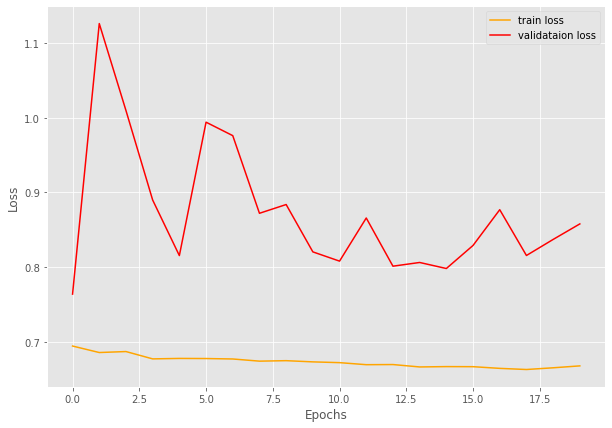

In [184]:
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/model.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()